## Import the data

In [93]:
import pandas as pd
import numpy as np
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

import numpy as np
import torch
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import rmsprop, adam, SGD
from torch.nn.functional import one_hot
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

In [94]:
# Features have already been pre-processed
train_x = pd.read_csv('/Users/sum02dean/projects/wine_challenge/WINE/data/scaled_unclipped_train_x.csv')
test_x = pd.read_csv('/Users/sum02dean/projects/wine_challenge/WINE/data/scaled_unclipped_test_x.csv')

# Labels
train_y = pd.read_csv('/Users/sum02dean/projects/wine_challenge/WINE/data/train_y.csv')
test_y = pd.read_csv('/Users/sum02dean/projects/wine_challenge/WINE/data/test_y.csv')

# Re-balance the labels train
train_y['class'] = 0
train_y.loc[train_y['quality'] > 5, 'class'] = 1
train_x['labels'] = train_y['class']

train_x_bad = train_x[train_x['labels'] == 0]
train_x_good = train_x[train_x['labels'] == 1]
train_x_good_sample = train_x_good.sample(n=np.shape(train_x_bad)[0])

# Re-balance the labels test
test_y['class'] = 0
test_y.loc[test_y['quality'] > 5, 'class'] = 1
test_x['labels'] = test_y['class']

test_x_bad = test_x[test_x['labels'] == 0]
test_x_good = test_x[test_x['labels'] == 1]
test_x_good_sample = test_x_good.sample(n=np.shape(test_x_bad)[0])

# Make the dataset balanced - train
train_x = pd.concat([train_x_good_sample, train_x_bad], axis=0)
train_y = train_x.loc[:, 'labels']
train_ohe_y = one_hot(torch.tensor(train_y.values)).numpy()
train_x = train_x.iloc[:, :-1].values
# Make the dataset balanced - test
test_x = pd.concat([test_x_good_sample, test_x_bad], axis=0)
test_y = test_x.loc[:, 'labels']
test_ohe_y = one_hot(torch.tensor(test_y.values)).numpy()
test_x = test_x.iloc[:, :-1].values


print(train_ohe_y.shape)
print(train_x.shape)

(3866, 2)
(3866, 13)


In [95]:
# Model
model_rf = RandomForestClassifier(n_jobs=-1, bootstrap=True)
model_svm = SVC()

# Search space
linear_space_est = np.linspace(1, 500, 5, dtype=int)
linear_space_dep = np.linspace(1, 20, 5, dtype=int)

params_rf = {
    'n_estimators': linear_space_est,
    'max_depth': linear_space_dep,
    'criterion': ['gini'],
    'max_features' : ['sqrt', 'log2'],
    }

params_svm = {
    'C': np.logspace(-4, 1, 5),
    'kernel': ['rbf'],
    'gamma': np.logspace(-4, 1, 5),
    }

# Determine classifier
classifiers = [
    GridSearchCV(model_svm, param_grid=params_svm, cv=5), 
    GridSearchCV(model_rf, param_grid=params_rf, cv=5)
]


0.868080703569581
{'C': 0.5623413251903491, 'gamma': 0.5623413251903491, 'kernel': 'rbf'}
0.7671840354767184
0.9979306777030522
{'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 500}
0.7993348115299335


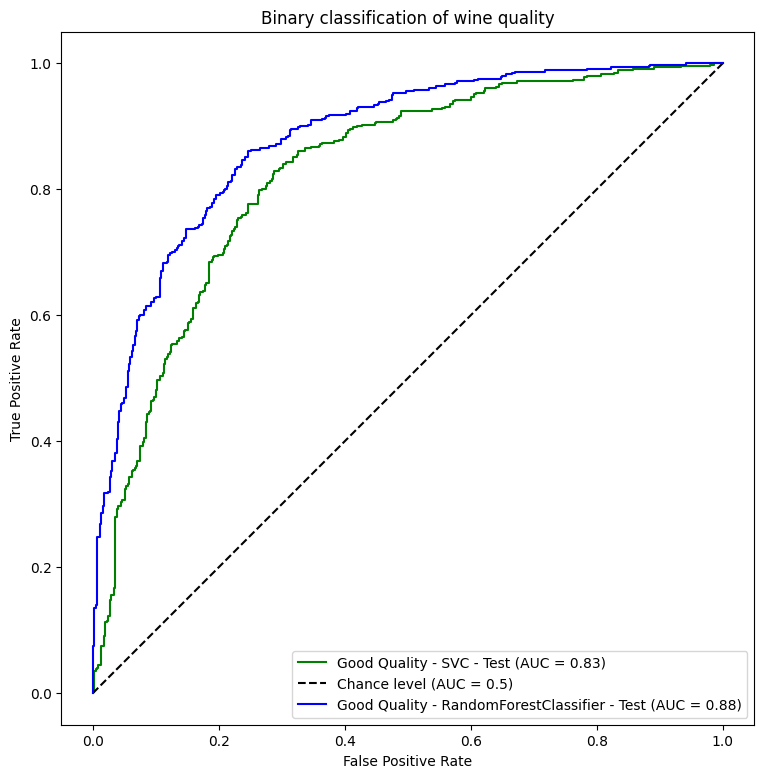

In [96]:
fig, axs = plt.subplots(figsize=(9,9))
diag = True
for clf, c, in zip(classifiers, ['green', 'blue']):
    
    # Predict on the train set
    trained_model = clf.fit(X=train_x, y=train_ohe_y[:, 0])
    preds = trained_model.predict(train_x)
    acc = accuracy_score(train_ohe_y[:, 0], preds)
    print(acc)

    # Infer on the test set
    test_pred = trained_model.predict(test_x)
    test_acc = accuracy_score(test_ohe_y[:, 0], test_pred)
    print(trained_model.best_params_)
    print(test_acc)

    # svc_disp =
    RocCurveDisplay.from_estimator(clf, test_x, test_ohe_y[:, 0],
    name=f"Good Quality - {clf.estimator.__class__.__name__} - Test",
    color=c,
    plot_chance_level=diag,
    ax=axs)
    diag = False

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary classification of wine quality")
plt.legend()
plt.show()


In [97]:
from collections import Counter 
Counter(pd.DataFrame(train_ohe_y))

Counter({0: 1, 1: 1})

In [98]:
Counter(pd.Series(train_ohe_y[:, 0]))

Counter({0: 1933, 1: 1933})